# Transfer learning

**Key ideas**: 
- Feature extraction layers may be gernerally useful
- Use a pre-trained model (e.g., pre-trained model on ImageNet)
- Freeze the weights: Only train last layer (or last few layers)

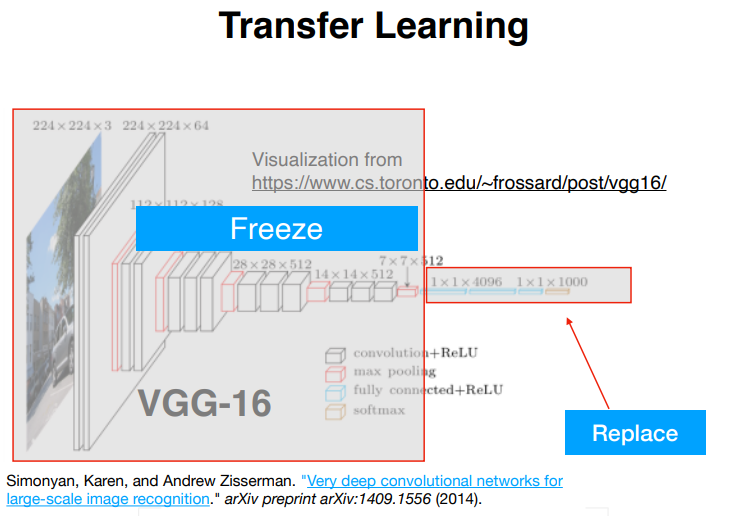

# Transfer Learning with Inception V3

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


# Utils
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# Sklearn imports
from sklearn.model_selection import train_test_split

# General Settings

In [2]:
if torch.cuda.is_available():
    device = torch.device(type='cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
RANDOM_SEED = 279

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [4]:
IMG_DIR = '../input/plant-seedlings-classification/train/'
TRAIN_DIR =  '../input/plant-seedlings-classification/train/'


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 235
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0001
LOGGING_INTERVAL = 100

# Create a dataframe of image files and their labels

In [5]:
class_label_names = os.listdir(TRAIN_DIR)
class_label_names

['Scentless Mayweed',
 'Common wheat',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherds Purse']

In [6]:
train_data = []

for index, class_label_name in tqdm(enumerate(class_label_names)):
    fnames = os.listdir(TRAIN_DIR + class_label_name) 
    for fname in fnames:
        train_data.append([f'{class_label_name}/{fname}', index])

df = pd.DataFrame(train_data, columns=[f'file_path', 'label'])
df

0it [00:00, ?it/s]

,file_path,label
0,Scentless Mayweed/4ae939d7d.png,0
1,Scentless Mayweed/b8664f705.png,0
2,Scentless Mayweed/628b08c82.png,0
3,Scentless Mayweed/9ab3b61db.png,0
4,Scentless Mayweed/086894274.png,0
...,...,...
4745,Shepherds Purse/f0127f70d.png,11
4746,Shepherds Purse/179cedc9e.png,11
4747,Shepherds Purse/a0ec33869.png,11
4748,Shepherds Purse/33010c8cb.png,11


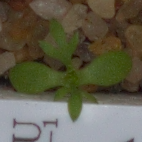

In [7]:
Image.open(IMG_DIR + train_data[0][0])

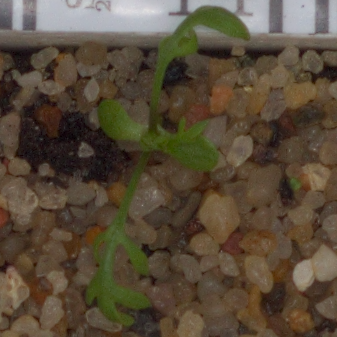

In [8]:
Image.open(IMG_DIR + train_data[1][0])

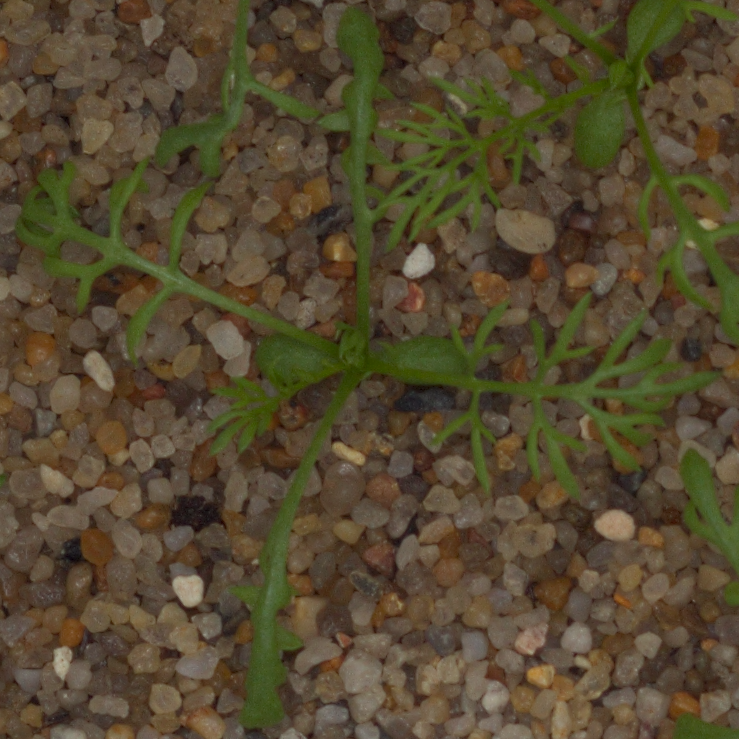

In [9]:
Image.open(IMG_DIR + train_data[3][0])

## Do train-test-split

In [10]:
X = df[['file_path']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.05,
                                                    stratify=y,
                                                    random_state=2001)

train = pd.concat([X_train, y_train.to_frame()], axis=1).reset_index(drop=True)
test = pd.concat([X_test, y_test.to_frame()], axis=1).reset_index(drop=True)
test.shape, train.shape

((238, 2), (4512, 2))

In [11]:
four_channels_idx = []
for i in tqdm(range(test.shape[0])):
    img = Image.open(IMG_DIR + test['file_path'][i])
    img = transforms.ToTensor()(img)
    if img.shape[0] == 4:
        four_channels_idx.append(i)

test = test.drop(four_channels_idx, axis=0).reset_index(drop=True)

  0%|          | 0/238 [00:00<?, ?it/s]

In [12]:
four_channels_idx = []
for i in tqdm(range(train.shape[0])):
    img = Image.open(IMG_DIR + train['file_path'][i])
    img = transforms.ToTensor()(img)
    if img.shape[0] == 4:
        four_channels_idx.append(i)

train = train.drop(four_channels_idx, axis=0).reset_index(drop=True)

  0%|          | 0/4512 [00:00<?, ?it/s]

In [13]:
test.shape, train.shape

((235, 2), (4491, 2))

## Datasets and DataLoaders

In [14]:
class PlantSeedingDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.file_path = df['file_path']
        self.y = df['label']
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.file_path[index]))
        
        if self.transform is not None:
            img = self.transform(img)
            
        label = self.y[index]
        
        return img, label
    
    def __len__(self):
        return self.y.shape[0]

In [15]:
train_transformers = transforms.Compose([
    transforms.Resize(size=(342, 342), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transformers = transforms.Compose([
    transforms.Resize(size=(342, 342), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [16]:
train_dataset = PlantSeedingDataset(df=train,
                                    img_dir=IMG_DIR,
                                    transform=train_transformers)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=TRAIN_BATCH_SIZE,
                          drop_last=True,
                          shuffle=True,
                          num_workers=0)


test_dataset = PlantSeedingDataset(df=test,
                                   img_dir=IMG_DIR,
                                   transform=test_transformers)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=TEST_BATCH_SIZE,
                         drop_last=False,
                         shuffle=False,
                         num_workers=0)

# Load pre-trained model

In [17]:
def load_inception_model():
    """
    Load the pre-trained Inception_V3 model
    """
    model = torchvision.models.inception_v3(pretrained=True)
    return model

model = load_inception_model()
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Freezing the model

In [18]:
model.aux_logits = False

for param in model.parameters():
    param.requires_grad = False

For the last layer, because the number of class labels differs compared to ImageNet, we replace the output layer with our own output layer:

In [19]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 1200),
    torch.nn.BatchNorm1d(1200),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1200, 12))

# Training

In [20]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [21]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_preds, num_examples = 0, 0
        for batch_idx, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            
            logits = model(features)
            _, predicted_labels = torch.max(F.softmax(logits, 1), 1)
            
            num_examples += targets.size(0)
            correct_preds += (predicted_labels==targets).sum()
        return (correct_preds/num_examples)*100

In [22]:
start_time = time.time()
mini_batch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, target) in enumerate(train_loader):
        
        ### Send data to GPUs
        features = features.to(device)
        target = target.to(device)
        
        ### FORWARD PASS AND BACKPROP
        logits = model(features)
        loss = F.cross_entropy(logits, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ### Logging
        mini_batch_loss_list.append(loss.item())
        if not batch_idx % LOGGING_INTERVAL:
            print(
                f'Epoch: {epoch + 1}/{NUM_EPOCHS}'
                f' | Batch: {batch_idx}/{len(train_loader)}'
                f' | Loss: {loss:.4f}')
        

    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device)
        valid_acc = compute_accuracy(model, test_loader, device)
        print(
            f'Epoch: {epoch + 1}/{NUM_EPOCHS}'
            f' | Train accuracy: {train_acc:.2f}%'
            f' | Valid accuracy: {valid_acc:.2f}%')
        
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())
    
    scheduler.step(valid_acc_list[-1])

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.3f} min')

elapsed = (time.time() - start_time)/60

print(f'Total training time: {elapsed:.3f} min')

Epoch: 1/10 | Batch: 0/280 | Loss: 2.3745
Epoch: 1/10 | Batch: 100/280 | Loss: 2.4823
Epoch: 1/10 | Batch: 200/280 | Loss: 1.8725
Epoch: 1/10 | Train accuracy: 78.93% | Valid accuracy: 74.04%
Time elapsed: 2.605 min
Epoch: 2/10 | Batch: 0/280 | Loss: 1.1613
Epoch: 2/10 | Batch: 100/280 | Loss: 0.8608
Epoch: 2/10 | Batch: 200/280 | Loss: 1.0169
Epoch: 2/10 | Train accuracy: 82.57% | Valid accuracy: 77.45%
Time elapsed: 5.024 min
Epoch: 3/10 | Batch: 0/280 | Loss: 1.0467
Epoch: 3/10 | Batch: 100/280 | Loss: 1.0961
Epoch: 3/10 | Batch: 200/280 | Loss: 0.6503
Epoch: 3/10 | Train accuracy: 87.03% | Valid accuracy: 79.57%
Time elapsed: 7.421 min
Epoch: 4/10 | Batch: 0/280 | Loss: 0.5788
Epoch: 4/10 | Batch: 100/280 | Loss: 0.8790
Epoch: 4/10 | Batch: 200/280 | Loss: 0.7304
Epoch: 4/10 | Train accuracy: 88.04% | Valid accuracy: 78.72%
Time elapsed: 9.818 min
Epoch: 5/10 | Batch: 0/280 | Loss: 0.6144
Epoch: 5/10 | Batch: 100/280 | Loss: 0.5039
Epoch: 5/10 | Batch: 200/280 | Loss: 0.8756
Epoch:

## Plot loss and accuracy 

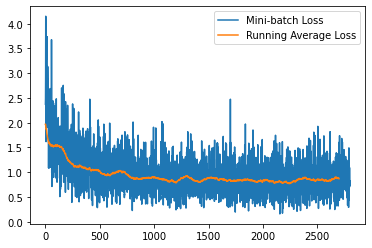

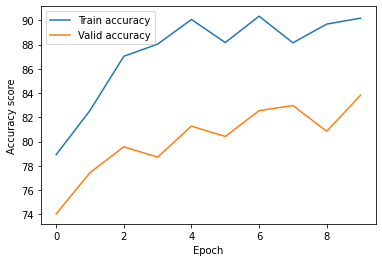

In [23]:
# Loss
plt.plot(range(len(mini_batch_loss_list)), mini_batch_loss_list, label='Mini-batch Loss')
plt.plot(np.convolve(mini_batch_loss_list, np.ones(100) / 100, mode='valid'), label='Running Average Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(range(len(train_acc_list)), train_acc_list, label='Train accuracy')
plt.plot(range(len(valid_acc_list)), valid_acc_list, label='Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()